In [350]:
%load_ext autoreload
%autoreload 2

import numpy as np
from castellers import *
import matplotlib.pyplot as plt
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The problem

We consider a 1-qubit (a spin 1/2 system) Hamiltonian which is $\hat{H} = \sigma_x =: X$. 

We consider a very simple <b>parametrized quantum circuit </b> (PQC), composed of two rotations aronud the y-axis and z-axis respectively (with angles $\theta, \phi$ respectively). The result of the unitary transformation generated by this circuit, and applied to the state $|0> = | \uparrow\rangle$ is

\begin{equation}
|\psi \rangle = \cos{\frac{\theta}{2}}|0 \rangle + \sin{\frac{\theta}{2} } e^{ i \phi}|1 \rangle,
\end{equation}

with $\theta \in [0, \pi]$ and $\phi \in [0, 2 \pi)$. The question is: <b>¿¿which angles do we choose, such that we can prepare the ground state of H??</b>


## Our approach 
<p>This problem is very simple, and it takes three lines to solve it with pen-and-paper! (it's a nice excercise to do so). Nonetheless, it's a good starting point to understand how quantum computers can be used to tackle problems of this kind (some of which are not that easy to be solved in pen-and-paper, nor even numerically using the best supercomputers on Earth). </p>
<p></p>
<p>...</p>

<p>Because this is just 1-qubit, we can quickly write a script that simulates the behaviour of the quantum computer (the action of gates, state-preparation, measurement, and energy estimation). For more sophisticated problems, one would typically use quantum-computing libraries such as Qiskit, TensorFlowQuantum, PennyLane, Q#, etc.</p>


## Our mini-library

<p> We wrote a tiny script named Castellers, in honor of this risky yet super cool Catalan tradition that consists of making human castles. Similarly, our script can be thought of a program-castle. At the very bottom we have the definitions of the circuit, state preparation, measurements, etc.. At the top we have the energy obtained by the prepared state, as computed by averaging over many outcomes coming from different experiment repetitions.</p>

<p>Variational Quantum Algorithms consists on having a (classical) optimization routine on top of the quantum measurements, which collects the value of the (measured) energy and proposes new values for $(\theta, \phi)$. Iterating the procedure of measuring energy and proposing new parameters, the optimization routine will hopefully find the optimal parameters (those which minimize the energy).</p>



##### Let's take a look on how things work

<p>In the code below, we define the $\texttt{QuantumCircuit()}$ object. This guy inherits the properties of quantum circuits that are useful for us (feel free to check out the code!). For instance, if the PQC consists on first rotating the initial state (which is ussually assumed to be $|0\rangle$ around the $y-axis$, and then rotating the resulting state around the $z$-axis:</p>

<img src="pqc.png" alt="image_pqc_1qbit">
<p>...</p>

<p>To get the unitary transformation representing this circuit, we use the function $\texttt{unitary(circuit)}$, where $\texttt{circuit}$ is a list that indicates which gates should be applied to the initial states (in the right order); in our example these are the two rotations, which are obtained as yet another functions $\texttt{qc.ry(th), qc.rz(phi)}$.</p>
<p>...</p>

<p>To get the quantum state output by the circuit (written in the <i> computational basis </i>, which is the basis of $|0\rangle$ and $|1\rangle$), we use the method $\texttt{qc.output_state(unitary)}$.</p>
<p>...</p>

<p>Finally, we would like to measure the mean value of our Hamiltonian using the prepared state. Note that whereas it is straightforward to measure $\sigma_z$ and its mean value (since we have the state written in the basis that diagonalize that operator), we should perform a change of basis in order to measure other operators (such as $\sigma_x$ $\sigma_y$). For instance, if we wanted to measure $\sigma_x$, a <i>Haddamard</i> should be appended at the end of the circuit, and then we can just measure on the computational basis in order to estimate the energy (this is yet another good excersise to do).</p>

In [225]:
qc = QuantumCircuit()

#
phi = 0.1
th = 0.2

circuit = [qc.ry(th), qc.rz(phi)]
print("circuit is  |0> ---- Ry(phi) --- Rz(th)----  \n\n")
unitary = qc.unitary(circuit)

unitary
print("the unitary transformation representing that circuit is \n {}\n\n".format( np.round(unitary,3)))

output_state = qc.output_state(unitary)

print("The state by the end of the circuit (if the initial state was |0>) is \n{}\n\n".format(output_state))

qc.observable_mean(output_state, operator="y")
print("The mean value of Sigma_y over the output state is \n{}".format(output_state))


circuit is  |0> ---- Ry(phi) --- Rz(th)----  


the unitary transformation representing that circuit is 
 [[ 0.995+0.j    -0.1  +0.j   ]
 [ 0.099-0.01j   0.99 -0.099j]]


The state by the end of the circuit (if the initial state was |0>) is 
[0.99500417+0.j         0.09933467-0.00996671j]


The mean value of Sigma_y over the output state is 
[0.99500417+0.j         0.09933467-0.00996671j]


Let us now study a bit what we get by different choices of parameters. Note that, as expected, the more number of shots (=measurement) we perform, the more accurate our estimates are. Moreover, we brute-force-numerically see that the optimal choice of parameters (minimum energy) is $\theta = \frac{\pi}{2}$ and $\phi = \pi$. <b>To which state does this correspond?</b>



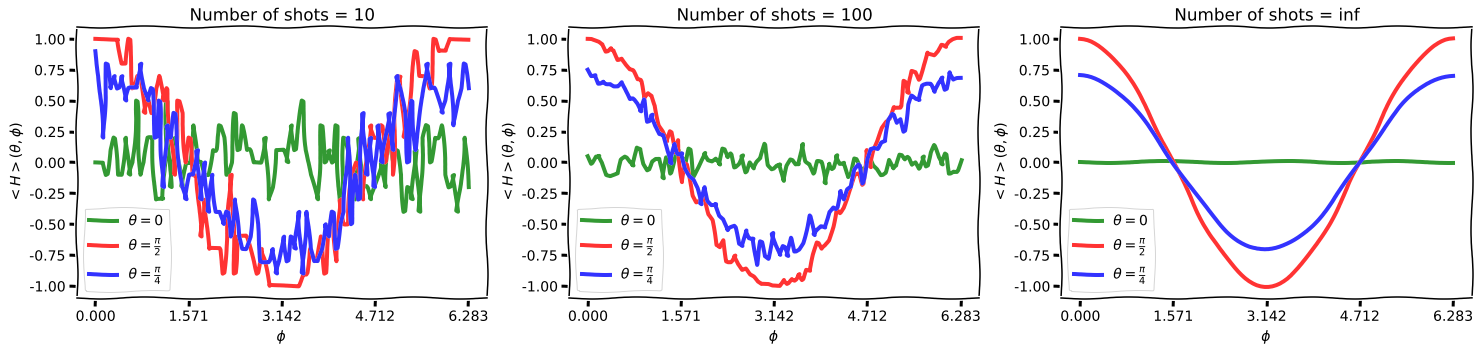

In [399]:
def mean_value_x(th,phi,shots=10):
    #this function generates a circuit determined by the values of (phi, th) and estimate
    #the mean value of \Sigma_x by measuring in the z-basis a "shots" number of repetitions.
    circuit = [qc.ry(th), qc.rz(phi)]
    unitary = qc.unitary(circuit)
    output_state = qc.output_state(unitary)
    return qc.observable_mean(output_state, operator="x", shots=shots)

def get_phis(th,shots=np.inf):
    #this is just a sweep over different values of the z-axis-rotation.
    mphi = []
    phis = np.linspace(0,2*np.pi,100)
    for ph in phis:
        mphi.append(mean_value_x(th, ph,shots=shots))
    return mphi
    
#plotting program
plt.xkcd()
plt.figure(figsize=(25,5))
ax1,ax2,ax3 = [plt.subplot2grid((1,3),(0,k)) for k in range(3)]
for ax, shot in zip([ax1,ax2,ax3],[10,100,np.inf]):
    ax.set_title("Number of shots = {}".format(shot))
    ax.plot(phis,get_phis(0,shots=shot),color="green", linewidth=4, alpha=.8,label=r'$\theta = 0$')
    ax.plot(phis,get_phis(np.pi/2,shots=shot),color="red", linewidth=4, alpha=.8,label=r'$\theta = \frac{\pi}{2}$')
    ax.plot(phis,get_phis(np.pi/4,shots=shot),color="blue", linewidth=4, alpha=.8,label=r'$\theta = \frac{\pi}{4}$')

    ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
    ax.legend()
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$<H>(\theta, \phi)$')

Note: there's a lot of things to talk from this simple example. For instance, one would think that a way to find the minimum value of the energy is to randomly sweep over $(\theta, \phi)$ and explore further the region that seems to contain the minima. This sounds good, but how would you sample those parameters? How would you sample uniformly at random those parameters? For this, one has to introduce the notion of the Haar measure of an unitary group; to find out more we recommend reading this <a href=https://pennylane.ai/qml/demos/tutorial_haar_measure.html >tutorial</a>

### Classical optimization

<p>Now we pose ourselfs in a situation at which we ignore the energy landscape, and we need to perform measurements in order to estimate where are the optimal parameters. There are many ways to do this, for example using a black-box optimizer that samples different regions of the parameter space according to some pre-defined strategy. Alternatively, we could imagine a situation at which one <i>measures</i> the gradient of the energy w.r.t. to some parameter; if this was the case, we could use gradient-based methods to aid the help over the parameter space. </p>

<p> ... </p>
<p>It turns out that measuring derivatives of parametrized quantum circuits is quite easy: one should simply evaluate the function we want to derive at two different points, and compute the difference. This is known as the parameter-shift rule, and we should note that is <b>exact</b>, not an approximation as we would do with finite differences (assuming we perform infinite number of measurements). You can <a href=https://pennylane.ai/qml/glossary/parameter_shift.html>learn more about parameter-shift rules here</a>; in the following we will just state the result.</p>

<p> </p>
<p> ... </p>
<p> Suppose we want to compute the derivative of $\langle\psi(\vec{\theta}) |H| \psi(\vec{\theta}) \rangle$, where $|\psi(\vec{\theta}) \rangle = U(\vec{\theta}) |0\rangle$. Here, $ U(\vec{\theta})$ represents a parametrized quantum circuit which in our case reads $R_y(\theta) R_z(\phi) = e^{- i \frac{\theta \sigma_y}{2}}  e^{- i \frac{\phi \sigma_z}{2}}$. The parameters of our circuits are of course $\vec{\theta} = (\theta, \phi)$. Then, it holds that

\begin{eqnarray}
\frac{\partial \langle\psi(\theta, \phi) |H| \psi(\theta, \phi) \rangle}{\partial \theta} &=&  \langle\psi(\theta + \frac{\pi}{2}, \phi) |H| \psi(\theta+ \frac{\pi}{2}, \phi) \rangle  -  \langle\psi(\theta - \frac{\pi}{2}, \phi) |H| \psi(\theta- \frac{\pi}{2}, \phi) \rangle \\
\frac{\partial \langle\psi(\theta, \phi) |H| \psi(\theta, \phi) \rangle}{\partial \phi} &=&  \langle\psi(\theta , \phi + \frac{\pi}{2}) |H| \psi(\theta, \phi+ \frac{\pi}{2}) \rangle  -  \langle\psi(\theta , \phi- \frac{\pi}{2}) |H| \psi(\theta, \phi- \frac{\pi}{2}) \rangle \\
\end{eqnarray}
</p>

<p> ... </p>
<p>This means that we do only need to measure the expected value of the hamiltonian on two different circuits (shifted by $\pm \frac{\pi}{2}$ so to measure the gradient. In the following, we will numerically check that this holds for our circuits, and then use this to optimize the parameters</p>



In [400]:
def get_gradients(th,phi,shots=10):
    
    gtheta = 0
    for shift, constant in zip([np.pi/2, -np.pi/2], [1,-1]):
        circuit = [qc.ry(th+shift), qc.rz(phi)]
        unitary = qc.unitary(circuit)
        output_state = qc.output_state(unitary)
        gtheta += constant*qc.observable_mean(output_state, operator="x", shots=shots)
    
    gphi = 0
    for shift, constant in zip([np.pi/2, -np.pi/2], [1,-1]):
        circuit = [qc.ry(th), qc.rz(phi+shift)]
        unitary = qc.unitary(circuit)
        output_state = qc.output_state(unitary)
        gphi += constant*qc.observable_mean(output_state, operator="x", shots=shots)
    return gtheta/2, gphi/2

### Let's compare with the true value.

It is easy to show that for the hamiltonian we are considering ($H=X$), it holds 
\begin{eqnarray}
\langle\psi |H| \psi \rangle &=& \sin \theta \cos \phi \\
|\psi \rangle &=& \cos{\frac{\theta}{2}}|0 \rangle + \sin{\frac{\theta}{2} } e^{ i \phi}|1 \rangle, \\
\end{eqnarray}
and hence 
\begin{eqnarray}
\frac{\partial \langle\psi |H| \psi \rangle}{\partial \theta} &=& - \sin \theta \sin \phi \\
\frac{\partial \langle\psi |H| \psi \rangle}{\partial \phi} &=&  \cos \theta \cos \phi \\
\end{eqnarray}

We can ues this information to check that things are OK with parameter-shift rule

#### Energy landscape

Text(0.5, 0, '$<H>$')

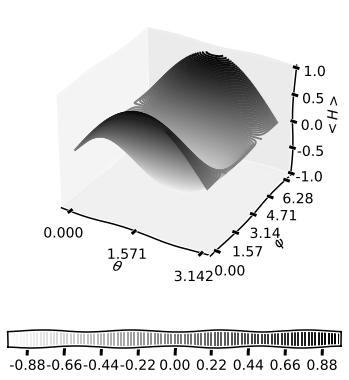

In [510]:
def energy_landscape(th, phi):
    return np.sin(th)*np.cos(phi)

thetas = np.linspace(0, np.pi, 100)
phis = np.linspace(0, 2*np.pi, 100)

Thetas, Phis = np.meshgrid(thetas, phis)
Energies = energy_landscape(Thetas, Phis)

fig = plt.figure(figsize=(6,7))

ax = plt.axes(projection='3d')
im=ax.contour3D(Thetas, Phis, Energies, 100, cmap="binary",vmin=-1,vmax=1)
colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")#,aspect=20,shrink=0.8)

ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')

### Gradients landscape

In [432]:
def grad_th(th, phi):
    ## this function gives the energy gradient wrt theta (analytical)
    return np.cos(th)*np.cos(phi)

### now we sweep over some values of theta, phi to measure gradients using the (simulated) quantum computer
### for each configuration we measure using 25 number of measurements (note that actually each gradient requires twice this value)
### since we are using the parameter-shift rule

ResTh, ResPh = 100, 100
thetas_qc = np.linspace(0, np.pi, ResTh)
phis_qc = np.linspace(0, 2*np.pi, ResPh)

th1d,ph1d,grad_th1d = [],[],[]

for indth, th in enumerate(tqdm(thetas_qc)):
    for indph, ph in enumerate(phis_qc):
        grads=get_gradients(th,ph,shots=25)

        th1d.append(th)
        ph1d.append(ph)
        grad_th1d.append(grads[0])


100%|██████████| 100/100 [00:02<00:00, 33.93it/s]


/home/cooper-cooper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 0, '$<H>$')

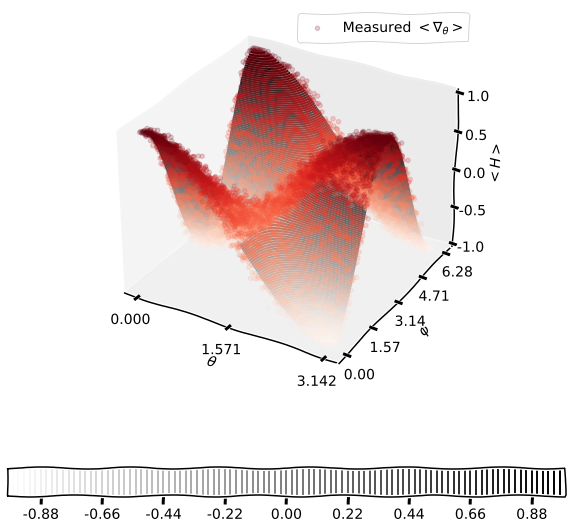

In [446]:
### Let's plot everything together!    
        
Thetas, Phis = np.meshgrid(thetas, phis)
Grad_th = grad_th(Thetas, Phis)

fig = plt.figure(figsize=(10,10))

ax = plt.axes(projection='3d')
ax.scatter3D(th1d,ph1d, grad_th1d,c=grad_th1d, alpha=0.2,cmap='Reds', label="Measured "+r'$< \nabla _\theta >$')
im=ax.contour3D(Thetas, Phis, Grad_th, 100, cmap="binary",vmin=-1,vmax=1, label="True")# "+r'$< \nabla _\theta >$'
colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")

ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.legend()
ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')

### Gradient-descent

In real-world problems, we don't have the luxury of plotting the energy landscape for different parameters, nor it is straigthforward to know which is the minimizing direction. To this end, we make use of classical optimization routines (which are the very same than we use in machine learning, e.g. SGD, Adam, etc.)

In [370]:
def gradient_descent_step(params, grads, lr=0.1):
    new_params = params - lr*grads
    return new_params

100%|██████████| 1000/1000 [00:00<00:00, 2949.31it/s]


Text(0, 0.5, 'Cost function (energy)')

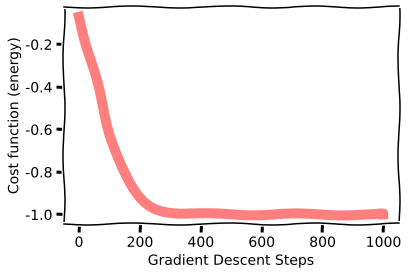

In [520]:
th, phi = np.pi/4, np.pi/2 + 0.1
params = np.array([th, phi])
trajectory_params = []
trajectory_energy=[]

energy = mean_value_x(*params,shots=np.inf)
trajectory_energy.append(energy)
trajectory_params.append([params])


for iteration in tqdm(range(1000)):
    grads = get_gradients(*params, shots=np.inf)
    params = gradient_descent_step(params,grads, lr=0.01)
    
    energy = mean_value_x(*params,shots=np.inf)
    trajectory_params.append([params])
    trajectory_energy.append(energy)
    
plt.plot(trajectory_energy, linewidth=10, color="red", alpha=0.5)
plt.xlabel("Gradient Descent Steps")
plt.ylabel("Cost function (energy)")

We can also plot the trajectory in the space $(\theta, \phi)$. Note that our optimizer does not take into account the restrictions of the parameters, so we chose some initial values s.t. we converge to a point inside that region. Otherwise we would obtain a point outisde, that we can map inside the are $\theta, \phi \in [0,\pi] \times [0, 2 \pi)$

Text(0.5, 0, '$<H>$')

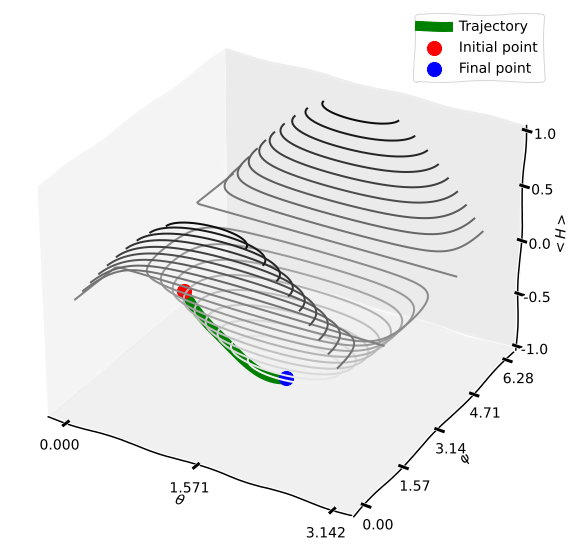

In [521]:
traj_params = np.squeeze(np.array(trajectory_params))

thetas = np.linspace(0, np.pi, 100)
phis = np.linspace(0, 2*np.pi, 100)

Thetas, Phis = np.meshgrid(thetas, phis)
Energies = energy_landscape(Thetas, Phis)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

ax.plot3D(traj_params[:,0],traj_params[:,1], trajectory_energy, alpha=1, linewidth=10, color="green", label="Trajectory")

im=ax.contour3D(Thetas, Phis, Energies, 20, cmap="binary",vmin=-1,vmax=1)

ax.scatter3D(traj_params[:,0][0],traj_params[:,1][0], trajectory_energy[0], s=200, color="red", label="Initial point")
ax.scatter3D(traj_params[:,0][-1],traj_params[:,1][-1], trajectory_energy[-1], s=200, color="blue", label="Final point")

#colorbar =fig.colorbar(im,ax=ax, orientation="horizontal")#,aspect=20,shrink=0.8)
ax.set_xticks(np.arange(0,2*np.pi+np.pi/2,np.pi/2))
ax.set_yticks(np.arange(0,2*np.pi+2*np.pi+np.pi/2,np.pi/2))
ax.set_zticks(np.arange(-1.,1.5,.5))

ax.legend()
ax.set_zlim([-1,1])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'$<H>$')